<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/2_Exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



This notebook will explore the nasdaq 100 companies.



In [ ]:
! pip install yfinance > /dev/null 2>&1
! mkdir hist

In [ ]:
# Load packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import os, contextlib
import shutil
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings

In [ ]:
warnings.filterwarnings('ignore')

#Load information for the companies for different analysis

In [ ]:
#load company info
wiki=pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')

In [ ]:
n100_list = wiki[3]
#creat df from the company info
n100 = n100_list
n100.head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,Advanced Micro Devices,AMD,Information Technology,Semiconductors
3,Alexion Pharmaceuticals,ALXN,Health Care,Pharmaceuticals
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [ ]:
#load thickers
ticker_list = list(n100["Ticker"])

In [ ]:
#load stock prices
dataframes = {}
df = pd. DataFrame()
for tick in ticker_list:
  dataframes[tick] = yf.download(tick, 
                      start='2019-01-01', 
                      end='2020-11-30', 
                      progress=False)
  df[tick] = dataframes[tick].iloc[:,3]

In [ ]:
#the close price which we will work with
df.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,47.029999,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,72.940002,191.899994,85.919998,143.009995,39.480000,33.480000,156.300003,89.029999,128.960007,130.139999,162.250000,304.690002,1721.699951,253.509995,43.230000,79.169998,51.869999,287.989990,103.500000,167.490005,42.950001,63.090000,34.369999,47.680000,204.759995,61.950001,115.180000,40.820000,91.199997,28.850000,80.370003,44.070000,...,298.010010,71.349998,32.750000,101.120003,15.330000,39.889999,48.759998,45.948002,267.660004,136.220001,75.029999,341.149994,63.259998,57.860001,65.070000,85.750000,NaN,109.279999,22.209999,57.400002,372.440002,83.779999,57.490002,5.90,67.959999,103.320000,64.320000,84.050003,65.260002,62.023998,94.449997,27.590000,147.759995,108.650002,164.080002,68.040001,159.740005,48.220001,86.849998,NaN
2019-01-03,45.360001,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,72.769997,188.979996,80.730003,137.639999,35.547501,31.540001,147.679993,84.480003,121.849998,126.209999,154.710007,307.000000,1663.119995,230.960007,41.529999,77.129997,50.700001,287.500000,102.349998,164.809998,41.070000,61.099998,34.639999,46.889999,200.419998,60.980000,112.260002,38.830002,90.760002,28.320000,78.709999,44.119999,...,296.589996,66.320000,31.000000,97.400002,15.500000,39.740002,48.000000,44.180000,271.200012,127.989998,71.970001,346.130005,59.560001,56.520000,63.970001,82.089996,NaN,108.260002,21.520000,55.700001,372.079987,83.080002,56.369999,5.94,60.720001,100.809998,61.529999,81.110001,65.019997,60.071999,88.879997,26.959999,142.589996,105.330002,163.729996,67.330002,154.020004,48.029999,83.580002,NaN
2019-01-04,47.169998,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,73.440002,195.440002,82.690002,143.660004,37.064999,33.700001,154.070007,87.089996,128.279999,131.240005,160.949997,318.329987,1717.550049,233.229996,43.259998,77.879997,52.230000,302.739990,105.349998,172.559998,42.919998,63.700001,35.810001,48.560001,206.240005,62.790001,116.239998,40.900002,92.889999,28.969999,84.419998,44.619999,...,315.329987,69.010002,32.700001,101.930000,16.959999,40.840000,49.790001,45.950001,297.570007,136.190002,75.449997,341.820007,63.150002,59.029999,66.199997,86.269997,NaN,110.480003,22.690001,56.599998,397.549988,85.339996,59.540001,6.17,63.630001,108.040001,63.570000,83.900002,67.489998,63.537998,92.900002,28.549999,148.970001,109.980003,172.699997,69.570000,163.350006,48.500000,87.449997,NaN
2019-01-07,48.500000,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,73.029999,198.070007,83.209999,147.320007,36.982498,34.299999,157.589996,92.709999,132.720001,130.529999,162.600006,322.399994,1711.819946,237.979996,43.419998,77.570000,51.930000,301.470001,104.870003,172.850006,43.209999,63.599998,35.430000,48.830002,207.000000,62.450001,129.949997,41.689999,97.959999,29.469999,87.589996,44.700001,...,328.940002,71.029999,34.000000,102.059998,16.270000,41.119999,49.730000,47.897999,315.339996,143.399994,76.010002,339.690002,66.269997,58.959999,65.849998,86.930000,NaN,109.529999,23.209999,56.439999,396.630005,88.930000,62.919998,6.22,64.489998,112.900002,63.570000,85.760002,68.440002,66.991997,94.500000,29.180000,151.399994,110.089996,175.850006,69.970001,163.500000,48.290001,89.760002,NaN
2019-01-08,49.970001,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,73.930000,200.610001,85.239998,148.050003,37.687500,32.910000,156.429993,94.820000,133.8699

In [ ]:
#rename the index
df.index.name = 'date'

In [ ]:
#load open prices
open = yf.download(ticker_list, start='2019-10-30', end='2020-12-01')['Open']

[*********************100%***********************]  102 of 102 completed


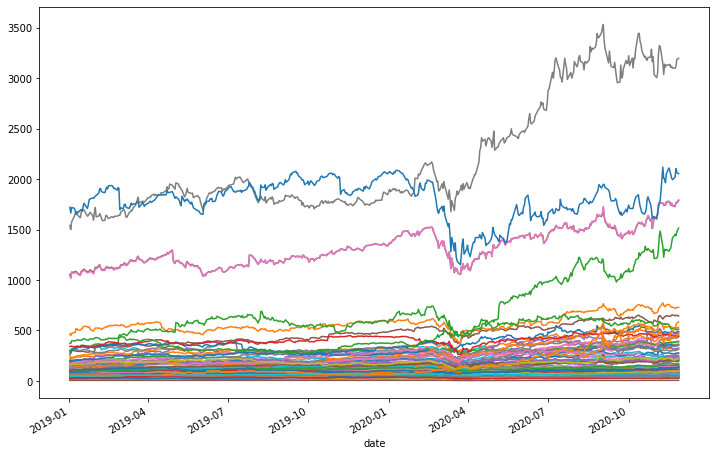

In [ ]:
#visualization for the companies through time
df.plot.line(legend=False, figsize=(12,8) )

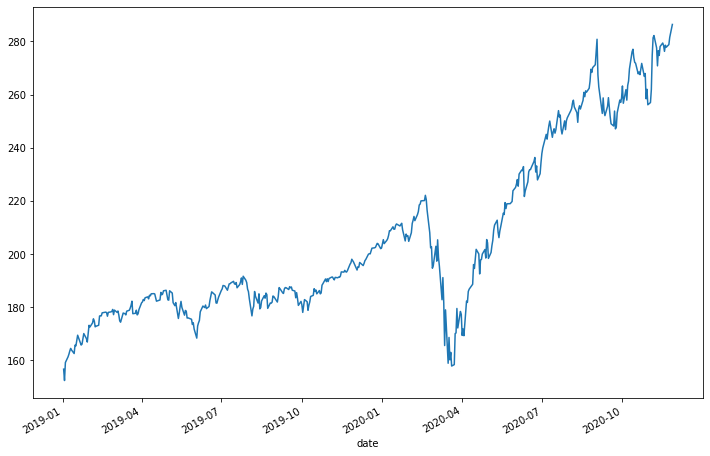

In [ ]:
#average of the 100 how it is developing
plt.figure(figsize=(12,8))
df['average'] = df.mean(axis=1)
df['average'].plot.line()

In [ ]:
stock_returns = df.apply(np.log).diff(1)

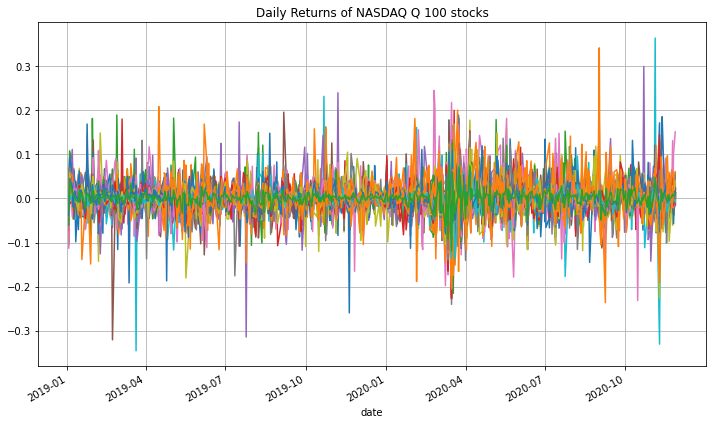

In [ ]:
#plot the returns development
stock_returns.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of NASDAQ Q 100 stocks')
plt.tight_layout()

In [ ]:
stock_returns.describe()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ASML,TEAM,ADSK,ADP,BIDU,BIIB,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,...,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,OKTA,PCAR,PAYX,PYPL,PTON,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TSLA,TXN,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM,average
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,296.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,407.000000,481.000000
mean,0.001056,0.001566,0.003186,0.000485,0.001779,0.001096,0.001121,0.001519,0.000316,0.000329,0.000981,0.001741,0.002251,0.001879,0.002141,0.001918,0.001558,0.000619,-0.000315,-0.000464,0.000366,0.000922,0.002062,0.001066,0.000742,0.001669,0.000303,0.001597,-0.000012,0.000452,0.000851,0.001834,0.001331,0.000806,0.002113,0.003566,0.000388,0.001198,0.000904,-0.000113,...,0.001295,0.001400,0.001570,0.004396,0.000759,0.001134,0.001473,0.001263,0.002826,0.001561,0.000544,0.002738,0.000866,0.000751,0.001876,0.004873,0.000582,0.003887,0.001910,0.000670,0.000557,0.002243,0.000217,0.001445,0.001415,0.000889,0.002051,0.001463,0.004668,0.001083,0.000447,0.000635,0.001250,0.000672,-0.001157,0.000702,0.000703,0.000955,0.004985,0.001254
std,0.023906,0.024251,0.036404,0.024530,0.038449,0.020499,0.020541,0.020212,0.018485,0.019671,0.026379,0.023268,0.024153,0.031611,0.025432,0.026830,0.026478,0.022148,0.025792,0.037501,0.026136,0.027322,0.024027,0.025398,0.016965,0.018570,0.017562,0.025537,0.022130,0.024437,0.019299,0.021865,0.014932,0.023306,0.032637,0.033030,0.025171,0.019939,0.023439,0.023236,...,0.031839,0.032852,0.021925,0.050867,0.016896,0.020221,0.026025,0.026035,0.032266,0.031729,0.021498,0.029669,0.019163,0.023336,0.026212,0.047013,0.017886,0.039078,0.029268,0.023451,0.027824,0.029185,0.021809,0.029946,0.030163,0.022345,0.022298,0.020677,0.045986,0.023046,0.029313,0.020382,0.018835,0.024614,0.025064,0.027960,0.018962,0.028741,0.046817,0.017356
min,-0.112462,-0.159525,-0.158280,-0.107274,-0.314546,-0.123685,-0.117667,-0.082535,-0.123103,-0.086220,-0.181700,-0.131797,-0.137708,-0.227624,-0.190545,-0.095016,-0.127864,-0.165495,-0.180553,-0.345742,-0.119205,-0.222055,-0.134653,-0.152523,-0.064214,-0.154654,-0.100780,-0.184656,-0.118615,-0.188498,-0.087358,-0.151511,-0.065238,-0.169017,-0.187498,-0.159155,-0.173398,-0.095770,-0.142777,-0.175415,...,-0.226830,-0.220878,-0.159453,-0.198047,-0.121374,-0.082664,-0.121326,-0.118095,-0.203979,-0.215431,-0.167529,-0.110354,-0.079211,-0.216667,-0.172259,-0.226717,-0.121358,-0.259912,-0.161875,-0.110813,-0.227651,-0.142469,-0.149641,-0.200805,-0.185260,-0.176788,-0.141438,-0.118882,-0.236518,-0.125855,-0.106380,-0.130485,-0.112936,-0.231875,-0.137025,-0.136439,-0.135726,-0.187258,-0.190800,-0.119149
25%,-0.011655,-0.008410,-0.015285,-0.013574,-0.014308,-0.006582,-0.006450,-0.008149,-0.005979,-0.008366,-0.010936,-0.008966,-0.007483,-0.011660,-0.008964,-0.013016,-0.009658,-0.006934,-0.013039,-0.010884,-0.010824,-0.009748,-0.008401,-0.008490,-0.006532,-0.005717,-0.006242,-0.007074,-0.008123,-0.007913,-0.007869,-0.005882,-0.005169,-0.008226,-0.013963,-0.010191,-0.009914,-0.008354,-0.009988,-0.008231,...,-0.013855,-0.015293,-0.007752,-0.023158,

#Preparing for unsupervised machine learning

In [ ]:
#create a time period
q1 = df.loc['2020-01-01':'2020-04-30']

In [ ]:
# Create empty dataframe
# add the tickers into the dataframe
stocks = pd.DataFrame(data=None, columns=['ticker', 'company', 'sector', 'industry'])
stocks['ticker']=q1.columns

In [ ]:
# add sector

for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['sector'][i] = n100['GICS Sector'][j]
    else: continue

# add industry

for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['industry'][i] = n100['GICS Sub-Industry'][j]
    else: continue

#add company names
for i in range(len(stocks)):
  for j in range(len(n100['Ticker'])):
    if stocks['ticker'][i] == n100['Ticker'][j]:
      stocks['company'][i] = n100['Company'][j]
    else: continue

In [ ]:
stocks['return'] = [(q1[i]['2020-04-30']/q1[i]['2020-01-02'] - 1) for i in stocks['ticker']]

In [ ]:
#displaying the returns for different companies 
print(len(stocks[stocks['return'] > 0]))
stocks[stocks['return'] > 0]

38


,ticker,company,sector,industry,return
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006
7,AMZN,Amazon.com,Consumer Discretionary,Internet & Direct Marketing Retail,0.303470
11,ANSS,ANSYS,Information Technology,Application Software,0.008629
15,TEAM,Atlassian,Information Technology,Application Software,0.265381
19,BIIB,Biogen,Health Care,Biotechnology,0.008802
22,CDNS,Cadence Design Systems,Information Technology,Application Software,0.135638
25,CHTR,"Charter Communications, Inc.",Communication Services,Cable & Satellite,0.009787
32,COST,Costco Wholesale Corporation,Consumer Staples,Hypermarkets & Super Centers,0.039487


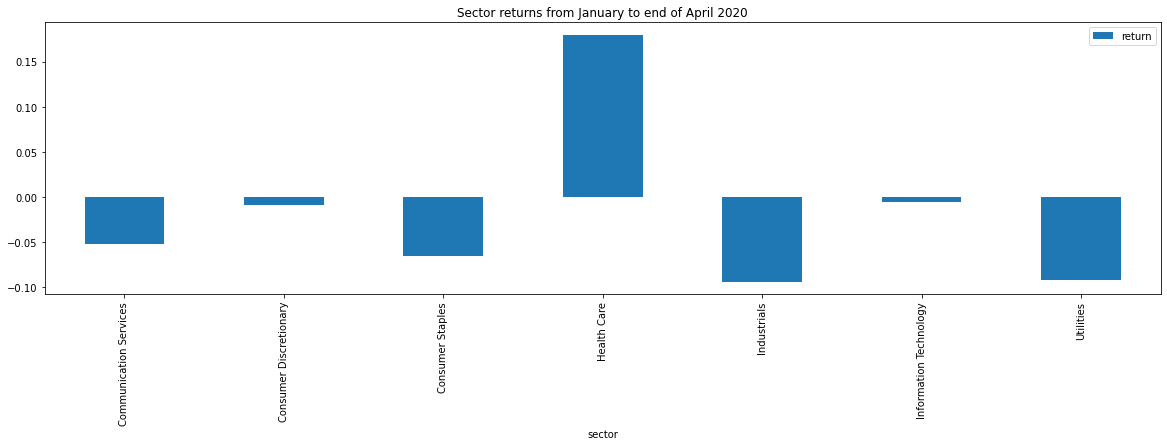

In [ ]:
#visualizing the returns in accordance to the sectors
sector_return = stocks.groupby('sector').mean()
sector_return.plot.bar(figsize=(20,5))
plt.title('Sector returns from January to end of April 2020')
plt.savefig('sectors.png', bbox_inches='tight')

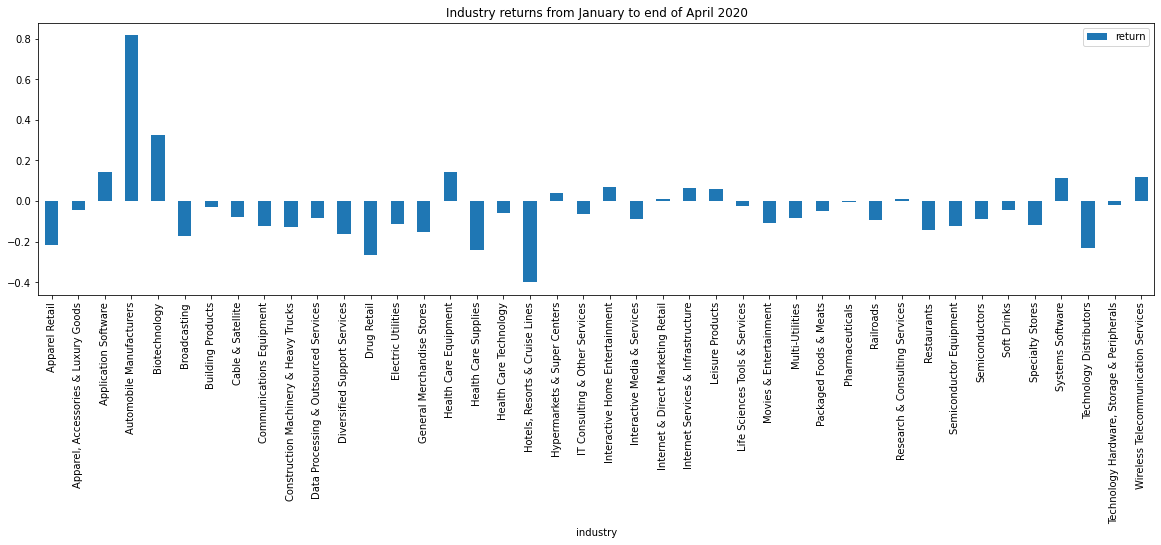

In [ ]:
#visualizing the returns according to the industry
industry_return = stocks.groupby('industry').mean()
industry_return.plot.bar(figsize=(20,5))
plt.title('Industry returns from January to end of April 2020')
plt.savefig('industries.png', bbox_inches='tight')

In [ ]:
#creating a column where we display positive, neutral or ngeative the return
stocks['return_class'] = 'tbd'
for i in range(len(stocks)):
  if stocks['return'][i] > 0:
    stocks['return_class'][i] = 'positive'
  elif stocks['return'][i] < 0:
    stocks['return_class'][i] = 'negative'
  else: stocks['return_class'][i] = 'neutral'

In [ ]:
stocks.head()

,ticker,company,sector,industry,return,return_class
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615,positive
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441,positive
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006,positive
3,ALXN,Alexion Pharmaceuticals,Health Care,Pharmaceuticals,-0.003431,negative
4,ALGN,Align Technology,Health Care,Health Care Supplies,-0.242633,negative


In [ ]:
#count the different classes
stocks['return_class'].value_counts()

negative    65
positive    38
Name: return_class, dtype: int64

In [ ]:
#get all the remaning information for the companies 
symbols_filtered = [x for x in  ticker_list]
len(symbols_filtered)

102

In [ ]:
#define which of the fundamental to keep
ts = yf.Ticker("ZM")
all = list(ts.info.keys())
to_keep = ['beta', 'enterpriseToEbitda', 'enterpriseToRevenue', 'forwardEps', 'trailingEps', 'forwardPE', 'trailingPE', 'fullTimeEmployees', 'priceToBook', 'profitMargins']
to_drop = [field for field in all if field not in to_keep]

In [ ]:
#get the statistics
n100_stats = {}
for symbol in symbols_filtered:
    ticker1 = yf.Ticker(symbol)
    temp = ticker1.info
 
    n100_stats[symbol] = temp

In [ ]:
#combine all the stats valuation tables into a single data frame
combined_stats = pd.DataFrame(n100_stats)

#filter not needed rows
#drope the missing values
combined_stats.drop(to_drop, inplace=True)
combined_stats.drop(['fax','underlyingSymbol','underlyingExchangeSymbol','headSymbol','uuid'], inplace=True)
combined_stats=combined_stats.transpose()
#display the data
combined_stats.head()

,fullTimeEmployees,beta,trailingPE,forwardPE,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,trailingEps,priceToBook
ATVI,9080,0.671916,30.888,24.8588,8.628,0.2889,22.798,3.54,2.849,4.72864
ADBE,NaN,0.967979,43.0572,35.2464,17.98,0.40877,46.337,13.23,10.83,16.8398
AMD,11400,2.26719,122.398,49.3607,12.767,0.10166,77.029,1.83,0.738,28.079
ALXN,3082,1.25459,36.6117,12.1728,5.989,0.16317,11.31,12.96,4.309,3.11964
ALGN,14530,1.67507,24.59,63.6502,18.398,0.75995,99.811,8.49,21.976,14.0463


In [ ]:
#merge the stock data and the statistical dataframe together
stock_stats = stocks.merge(combined_stats, left_on='ticker', right_index=True, how='outer')
stock_stats.head()

,ticker,company,sector,industry,return,return_class,fullTimeEmployees,beta,trailingPE,forwardPE,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,trailingEps,priceToBook
0,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.086615,positive,9080,0.671916,30.888,24.8588,8.628,0.2889,22.798,3.54,2.849,4.72864
1,ADBE,Adobe Inc.,Information Technology,Application Software,0.057441,positive,NaN,0.967979,43.0572,35.2464,17.98,0.40877,46.337,13.23,10.83,16.8398
2,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.067006,positive,11400,2.26719,122.398,49.3607,12.767,0.10166,77.029,1.83,0.738,28.079
3,ALXN,Alexion Pharmaceuticals,Health Care,Pharmaceuticals,-0.003431,negative,3082,1.25459,36.6117,12.1728,5.989,0.16317,11.31,12.96,4.309,3.11964
4,ALGN,Align Technology,Health Care,Health Care Supplies,-0.242633,negative,14530,1.67507,24.59,63.6502,18.398,0.75995,99.811,8.49,21.976,14.0463


In [ ]:
#creat a full statistical dataframe and deplace the None
stock_stats_full=stock_stats.replace('None',np.nan)
#impute missing values
imp=SimpleImputer(missing_values=np.nan)
# Check for NaN values
print(stock_stats.isna().sum().sum())

52


In [ ]:
#drop rows with NaN values since PCA cannot deal with them and extrapolating affects the result
stock_stats_full = imp.fit_transform(stock_stats_full.loc[:,'fullTimeEmployees':'priceToBook'])
# scale all relevant variables into a new matrix
stock_stats_scaled = StandardScaler().fit_transform(stock_stats_full)

#Unsupervised Machine Learning

##UMAP cluster analissi for the comapny indicators

In [ ]:
reducer = umap.UMAP()

In [ ]:
#UMAP with 2 components
umap_stocks = reducer.fit_transform(stock_stats_scaled)
umap_stocks.shape

(103, 2)

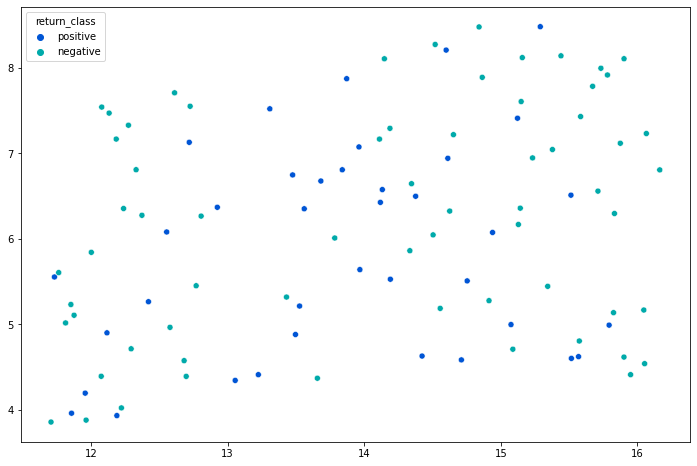

In [ ]:
#display the umap in case od the return class
plt.figure(figsize=(12,8))
sns_plot = sns.scatterplot(umap_stocks[:,0], umap_stocks[:,1], hue = stock_stats['return_class'],palette = "winter")
figure = sns_plot.get_figure()    
figure.savefig('UMAP with 2 components')

In [ ]:
# UMAP with 2 components
reducer = umap.UMAP(n_components=2)
umap_stocks = reducer.fit_transform(stock_stats_scaled)
umap_stocks.shape

(103, 2)

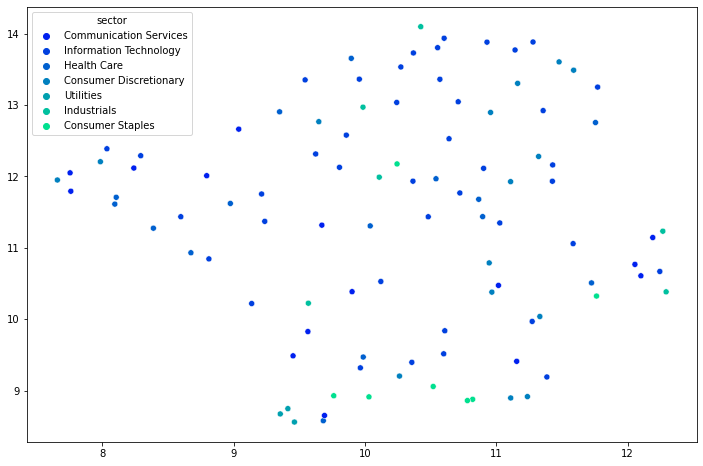

In [ ]:
#display the UMAP according to the sectors
plt.figure(figsize=(12,8))
sns_plot = sns.scatterplot(umap_stocks[:,0], umap_stocks[:,1], hue = stock_stats['sector'],palette = "winter")
figure = sns_plot.get_figure()    
figure.savefig('UMAP with 8 components')

shows that the There is now growth distribution in different sectors if we would have a separate cluster of dots it would mean that that sector is outstand for some reason but this means taht we sould invest in cross sector


##UML for the stock prices

In [ ]:
#get ready for clustering
df_for_clustering = df.transpose()
df_for_clustering

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,...,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27
ATVI,47.029999,45.360001,47.169998,48.500000,49.970001,50.830002,51.349998,46.540001,47.290001,46.840000,47.130001,47.380001,48.650002,47.060001,46.020000,47.270000,47.799999,46.740002,45.730000,46.310001,47.240002,46.009998,46.779999,47.840000,43.000000,43.959999,43.410000,40.110001,41.669998,44.570000,45.430000,44.599998,44.480000,42.779999,41.900002,41.500000,41.959999,42.080002,41.790001,42.139999,...,78.300003,79.989998,78.300003,78.470001,77.800003,78.209999,81.059998,81.980003,81.900002,80.349998,80.620003,80.080002,80.139999,81.940002,80.769997,81.040001,80.489998,80.959999,79.010002,77.769997,75.730003,76.400002,76.260002,79.370003,80.139999,78.809998,75.410004,75.120003,76.550003,76.709999,77.550003,77.440002,77.110001,75.500000,75.930000,76.809998,75.919998,75.230003,76.510002,78.139999
ADBE,224.570007,215.699997,226.190002,229.259995,232.679993,235.429993,237.770004,237.550003,234.559998,242.360001,241.949997,244.399994,247.509995,243.850006,245.139999,242.559998,244.949997,241.850006,238.270004,242.669998,247.820007,247.380005,254.740005,254.820007,254.350006,253.740005,257.000000,258.390015,261.369995,260.230011,260.140015,259.450012,257.809998,258.100006,257.760010,258.899994,258.619995,261.220001,262.899994,262.500000,...,478.989990,486.470001,478.980011,493.149994,490.839996,502.160004,510.890015,514.309998,506.309998,501.149994,502.820007,495.200012,494.579987,495.959991,483.600006,488.500000,475.200012,478.559998,456.970001,461.109985,447.100006,444.940002,454.019989,487.230011,496.470001,494.630005,471.140015,452.000000,467.750000,462.579987,469.339996,460.950012,467.950012,459.470001,466.410004,462.920013,460.609985,462.700012,470.079987,477.029999
AMD,18.830000,17.049999,19.000000,20.570000,20.750000,20.190001,19.740000,20.270000,20.230000,20.379999,19.730000,20.250000,20.770000,19.760000,19.799999,20.850000,21.930000,20.180000,19.250000,23.090000,24.410000,24.510000,24.129999,23.309999,23.260000,22.670000,23.049999,22.959999,22.820000,22.850000,23.129999,23.680000,23.950001,23.950001,23.920000,24.360001,24.709999,24.209999,23.480000,23.530001,...,81.800003,86.150002,84.480003,86.690002,86.510002,83.099998,84.290001,85.279999,84.209999,83.129997,83.169998,82.000000,81.559998,79.199997,79.419998,81.959999,82.230003,78.879997,76.400002,78.019997,75.290001,74.699997,76.580002,81.349998,83.000000,85.879997,83.120003,77.989998,81.279999,81.839996,81.430000,83.730003,83.360001,82.540001,85.540001,84.639999,85.309998,85.070000,86.709999,87.190002
ALXN,98.050003,100.209999,106.000000,107.940002,108.610001,109.959999,110.930000,111.129997,107.580002,111.730003,111.699997,114.620003,117.050003,114.290001,117.000000,117.910004,121.440002,119.209999,119.610001,121.320000,122.959999,126.279999,123.750000,122.870003,121.029999,118.790001,120.139999,120.050003,124.260002,125.180000,125.930000,129.419998,128.929993,129.839996,127.550003,129.729996,133.169998,133.289993,136.009995,135.330002,...,111.550003,115.250000,116.080002,125.330002,123.139999,124.519997,124.379997,123.750000,122.519997,122.029999,124.129997,121.760002,124.000000,118.190002,119

In [ ]:
#get rid of the missing values
df_for_clustering.dropna(inplace=True)
df_for_clustering=df_for_clustering[:-1]
df_for_clustering

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-25,2019-02-26,2019-02-27,2019-02-28,...,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27
ATVI,47.029999,45.360001,47.169998,48.500000,49.970001,50.830002,51.349998,46.540001,47.290001,46.840000,47.130001,47.380001,48.650002,47.060001,46.020000,47.270000,47.799999,46.740002,45.730000,46.310001,47.240002,46.009998,46.779999,47.840000,43.000000,43.959999,43.410000,40.110001,41.669998,44.570000,45.430000,44.599998,44.480000,42.779999,41.900002,41.500000,41.959999,42.080002,41.790001,42.139999,...,78.300003,79.989998,78.300003,78.470001,77.800003,78.209999,81.059998,81.980003,81.900002,80.349998,80.620003,80.080002,80.139999,81.940002,80.769997,81.040001,80.489998,80.959999,79.010002,77.769997,75.730003,76.400002,76.260002,79.370003,80.139999,78.809998,75.410004,75.120003,76.550003,76.709999,77.550003,77.440002,77.110001,75.500000,75.930000,76.809998,75.919998,75.230003,76.510002,78.139999
ADBE,224.570007,215.699997,226.190002,229.259995,232.679993,235.429993,237.770004,237.550003,234.559998,242.360001,241.949997,244.399994,247.509995,243.850006,245.139999,242.559998,244.949997,241.850006,238.270004,242.669998,247.820007,247.380005,254.740005,254.820007,254.350006,253.740005,257.000000,258.390015,261.369995,260.230011,260.140015,259.450012,257.809998,258.100006,257.760010,258.899994,258.619995,261.220001,262.899994,262.500000,...,478.989990,486.470001,478.980011,493.149994,490.839996,502.160004,510.890015,514.309998,506.309998,501.149994,502.820007,495.200012,494.579987,495.959991,483.600006,488.500000,475.200012,478.559998,456.970001,461.109985,447.100006,444.940002,454.019989,487.230011,496.470001,494.630005,471.140015,452.000000,467.750000,462.579987,469.339996,460.950012,467.950012,459.470001,466.410004,462.920013,460.609985,462.700012,470.079987,477.029999
AMD,18.830000,17.049999,19.000000,20.570000,20.750000,20.190001,19.740000,20.270000,20.230000,20.379999,19.730000,20.250000,20.770000,19.760000,19.799999,20.850000,21.930000,20.180000,19.250000,23.090000,24.410000,24.510000,24.129999,23.309999,23.260000,22.670000,23.049999,22.959999,22.820000,22.850000,23.129999,23.680000,23.950001,23.950001,23.920000,24.360001,24.709999,24.209999,23.480000,23.530001,...,81.800003,86.150002,84.480003,86.690002,86.510002,83.099998,84.290001,85.279999,84.209999,83.129997,83.169998,82.000000,81.559998,79.199997,79.419998,81.959999,82.230003,78.879997,76.400002,78.019997,75.290001,74.699997,76.580002,81.349998,83.000000,85.879997,83.120003,77.989998,81.279999,81.839996,81.430000,83.730003,83.360001,82.540001,85.540001,84.639999,85.309998,85.070000,86.709999,87.190002
ALXN,98.050003,100.209999,106.000000,107.940002,108.610001,109.959999,110.930000,111.129997,107.580002,111.730003,111.699997,114.620003,117.050003,114.290001,117.000000,117.910004,121.440002,119.209999,119.610001,121.320000,122.959999,126.279999,123.750000,122.870003,121.029999,118.790001,120.139999,120.050003,124.260002,125.180000,125.930000,129.419998,128.929993,129.839996,127.550003,129.729996,133.169998,133.289993,136.009995,135.330002,...,111.550003,115.250000,116.080002,125.330002,123.139999,124.519997,124.379997,123.750000,122.519997,122.029999,124.129997,121.760002,124.000000,118.190002,119

In [ ]:
#scale the data
df_scaled = StandardScaler().fit_transform(df_for_clustering)
umap_reducer = umap.UMAP()
df_reduced = umap_reducer.fit_transform(df_scaled)

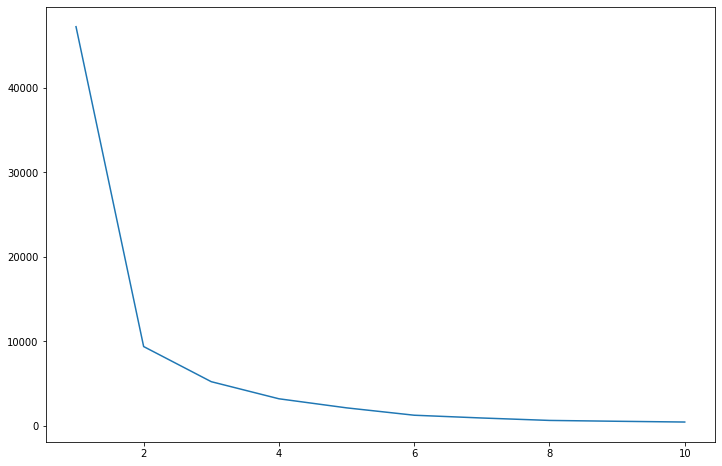

In [ ]:
#initialize the clusters
inertia = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    inertia.append(kmeanModel.inertia_)
plt.figure(figsize=(12,8))
sns.lineplot(K, inertia)

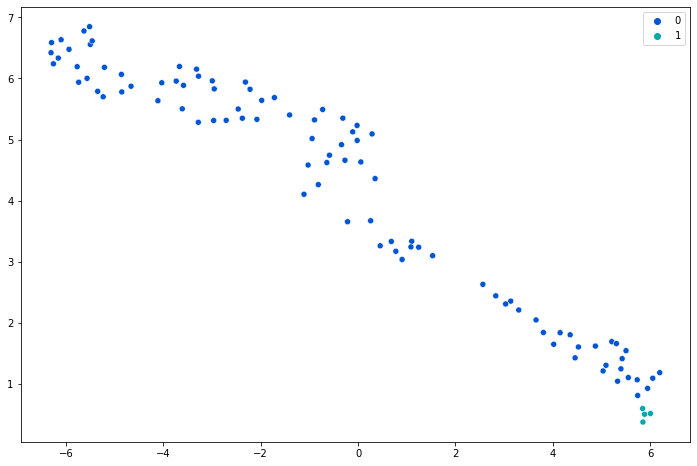

In [ ]:
#visualization of the clusters
clusterer = KMeans(n_clusters=2)
clusterer.fit(df_scaled)
plt.figure(figsize=(12,8))
sns.scatterplot(df_reduced[:,0], df_reduced[:,1],hue = clusterer.labels_, palette = "winter")

In [ ]:
#display the outstanding companies according to the clustering
df_for_clustering["cluster"] = clusterer.labels_
df_for_clustering[df_for_clustering["cluster"]==1]

date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
GOOGL,1054.680054,1025.469971,1078.069946,1075.920044,1085.369995,1081.650024,1078.829956,1064.469971,1051.510010,1086.510010,1089.510010,1099.119995,1107.300049,1078.630005,1084.410034,1084.000000,1101.510010,1079.859985,1070.060059,1097.989990,1125.890015,1118.619995,1141.420044,1151.869995,1122.890015,1105.910034,1102.380005,1102.119995,1127.579956,1128.630005,1129.199951,1119.630005,1126.510010,1120.589966,1104.209961,1116.560059,1117.329956,1122.010010,1122.890015,1126.550049,...,1482.829956,1451.020020,1459.140015,1483.430054,1510.449951,1564.589966,1567.069946,1563.439941,1555.469971,1567.699951,1529.949951,1551.079956,1585.989990,1606.660034,1632.979980,1584.290039,1598.880005,1510.800049,1556.880005,1616.109985,1624.319946,1645.660034,1745.849976,1762.500000,1759.729980,1761.420044,1737.719971,1747.229980,1742.819946,1772.260010,1774.030029,1761.660034,1740.640015,1758.569946,1736.380005,1727.560059,1763.900024,1764.130005,1787.020020,1
GOOG,1045.849976,1016.059998,1070.709961,1068.390015,1076.280029,1074.660034,1070.329956,1057.189941,1044.689941,1077.150024,1080.969971,1089.900024,1098.260010,1070.520020,1075.569946,1073.900024,1090.989990,1070.079956,1060.619995,1089.060059,1116.369995,1110.750000,1132.800049,1145.989990,1115.229980,1098.709961,1095.060059,1095.010010,1121.369995,1120.160034,1121.670044,1113.650024,1118.560059,1113.800049,1096.969971,1110.369995,1109.400024,1115.130005,1116.050049,1119.920044,...,1486.020020,1453.439941,1460.290039,1485.930054,1515.219971,1569.150024,1571.680054,1568.079956,1559.130005,1573.010010,1534.609985,1555.930054,1593.310059,1615.329956,1641.000000,1590.449951,1604.260010,1516.619995,1567.239990,1621.010010,1626.030029,1650.209961,1749.130005,1763.369995,1761.750000,1763.000000,1740.390015,1752.709961,1749.839966,1777.020020,1781.380005,1770.150024,1746.780029,1763.920044,1742.189941,1734.859985,1768.880005,1771.430054,1793.189941,1
AMZN,1539.130005,1500.280029,1575.390015,1629.510010,1656.579956,1659.420044,1656.219971,1640.560059,1617.209961,1674.560059,1683.780029,1693.219971,1696.199951,1632.170044,1640.020020,1654.930054,1670.569946,1637.890015,1593.880005,1670.430054,1718.729980,1626.229980,1633.310059,1658.810059,1640.260010,1614.369995,1588.219971,1591.000000,1638.010010,1640.000000,1622.650024,1607.949951,1627.579956,1622.099976,1619.439941,1631.560059,1633.000000,1636.400024,1641.089966,1639.829956

In [ ]:
df_for_clustering[df_for_clustering["cluster"]==1].describe()

date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
mean,1340.339996,1301.232498,1360.429993,1371.410004,1376.287506,1366.305023,1370.677460,1357.027496,1351.572479,1384.132538,1383.707489,1401.687500,1415.505005,1372.575012,1386.077515,1402.125031,1416.317474,1400.357483,1383.340027,1419.045013,1448.450012,1423.139984,1442.130035,1464.732513,1446.327515,1424.012512,1414.187500,1413.282501,1445.562500,1452.190002,1443.962494,1443.699982,1452.037506,1445.665009,1431.732483,1442.252533,1437.440002,1447.317505,1446.507507,1395.835022,...,1968.709991,1928.532471,1968.492493,1987.180054,2032.552460,2105.417480,2090.837463,2056.957458,2038.839966,2020.322479,1981.197479,1998.932495,2016.567505,2047.602478,2075.482483,2032.767517,2046.795013,1948.812531,1991.347504,1973.942474,1964.739990,2003.464966,2112.364960,2154.045013,2154.150024,2196.600006,2130.142487,2159.337463,2141.464996,2182.740051,2199.020050,2187.179993,2159.369995,2162.619995,2142.684967,2145.162476,2188.572510,2196.107544,2207.054993,1.0
std,343.161215,330.631117,335.364199,347.193497,341.415639,332.763885,342.030148,342.188659,351.789936,349.224423,344.660707,354.947921,362.068294,345.542457,356.012907,377.590275,373.493113,382.532331,377.551705,380.738277,380.835046,366.429823,364.282401,377.966557,393.277640,386.651862,382.148925,380.241893,385.358959,395.400921,385.131080,400.376889,400.718727,399.091686,399.914536,396.372462,388.656710,396.373539,392.821460,315.648255,...,826.997908,790.328351,830.195407,814.957182,848.344328,901.264668,907.362849,874.713407,869.225930,836.192314,819.323252,813.963652,780.720145,757.362923,757.739618,786.564749,827.601481,810.459757,813.754672,708.143547,693.231335,696.707162,752.703535,778.640861,771.5

In [ ]:
df_for_clustering[df_for_clustering["cluster"]==0].describe()

date,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-18 00:00:00,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-04 00:00:00,2019-02-05 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-11 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,...,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-12 00:00:00,2020-10-13 00:00:00,2020-10-14 00:00:00,2020-10-15 00:00:00,2020-10-16 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-11-02 00:00:00,2020-11-03 00:00:00,2020-11-04 00:00:00,2020-11-05 00:00:00,2020-11-06 00:00:00,2020-11-09 00:00:00,2020-11-10 00:00:00,2020-11-11 00:00:00,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00,2020-11-27 00:00:00,cluster
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0
mean,106.282923,103.481783,108.024881,109.768892,110.571633,112.268850,113.123247,113.086171,111.930501,113.836352,113.570936,114.862720,116.402990,114.361920,114.159370,115.535276,117.014309,115.718664,115.085555,117.000749,118.885120,119.288107,120.107606,120.748228,120.650255,119.321841,119.984427,120.404910,122.654677,122.468491,122.796592,123.985606,123.901065,124.014269,123.164420,124.228648,124.622979,124.359582,125.197876,125.303342,...,193.424787,190.930320,195.105212,196.166596,198.928192,202.809361,204.182234,202.281701,200.809947,201.062020,198.271595,198.636277,197.122447,197.968191,199.231703,195.730319,196.064627,190.177765,192.584361,187.340425,188.670213,192.371489,201.347340,206.485852,207.374042,201.742979,197.537340,202.091701,200.731915,202.964149,203.713299,203.104789,201.788723,204.158086,203.847446,204.895531,206.099150,207.361809,210.068831,0.0
std,87.267670,85.859697,89.895681,91.197318,91.193149,93.819969,94.484273,94.279012,93.327959,95.631988,95.374886,97.171012,97.828426,95.722900,95.113526,95.650241,95.516168,94.209356,93.907003,95.269573,97.796558,97.971818,98.518611,98.623002,97.939093,96.524064,97.044286,97.778028,100.055693,99.330402,99.931566,101.486464,101.542210,101.699659,100.780489,101.937701,101.941499,101.663054,104.134413,104.399375,...,177.438986,175.098196,180.767807,182.135189,185.596500,188.980931,193.185181,190.140764,190.123325,191.020741,189.575770,192.033259,188.715725,189.198233,191.220143,187.371867,187.706834,183.391811,185.827259,177.746254,178.793508,182.010388,192.536760,202.345443,205.652655,192.644412,184.048309,1

Based on the outcomes of .describe( it can be seen, that the average value of the stocks in the small cluster is vastly higher than the average value within the other cluster.

In [ ]:
#get the desired company
df_out=df.loc[:,['TSLA','GOOGL','ALXN','AMZN']]

In [ ]:
#save csv
df_out.to_csv("yf_chosen_comp.csv")